# `comp-00`: Multivariate pattern analysis (MVPA)
This demo introduces multivariate pattern analysis (MVPA) using one of the datasets that popularized the application of machine learning to fMRI. Specifically, we will use classification models (e.g. the support vector machine; SVM) to differentiate between spatially-distributed cortical response patterns corresponding to different object stimuli (e.g. faces, houses, etc). Rather than using a regression model to predict brain activity at each voxel from the stimulus/task (sometimes referred to as an "encoding" model), multivariate pattern classification models predict the stimulus or task from distributed patterns of brain activity (referred to as a "decoding" model).

In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

### Visual object recognition dataset
We'll demo multivariate pattern classification on the visual object recognition dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). This study popularized machine learning in fMRI and spurred a debate about localized versus distributed representation in human brain activity. Participants were presented with images from 8 object categories (bottles, cats, chairs, faces, houses, scissors, scrambled images, and shoes) interspersed with periods of fixation (referred to as "rest" here). The TR in this study was 2.5 seconds. In a given run, a block of images from each of the 8 categories was presented one time. Each block was ~9 TRs long and contained multiple rapid presentations of images from a single category. A subject received 12 scanning runs. We'll focus on data from one subject for the purposes of this demo.

In [2]:
pwd

'/mnt/cup/people/zj4962/neu502b/neu502b-2024/comp-00'

In [3]:
# Download Haxby 2001 data
from nilearn import datasets

# If you're on your local machine, change this path
data_dir = '/mnt/cup/people/zj4962/neu502b/nilearn-data'

haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)


Dataset created in /mnt/cup/people/zj4962/neu502b/nilearn-data/haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 272015360 of 291168628 bytes (93.4%,    0.2s remaining) ...done. (4 seconds, 0 min)
Extracting data from /mnt/cup/people/zj4962/neu502b/nilearn-data/haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz..... done.


We'll need to extract certain attributes of the dataset, namely: the stimulus labels and the run labels. We'll exclude the the fixation TRs (the "rest" labels) from our analysis.

In [10]:
# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Create a boolean array indexing TRs containing a stimulus (non-rest)
task_trs = stimuli != 'rest'

# Get list of unique stimulus categories (excluding rest)
categories = [c for c in np.unique(stimuli) if c != 'rest']

Load in the functional data using `index_img` to select only the task TRs; i.e. excluding intervening fixation (`'rest'`) periods. Check and interpret the shapes of the `stimuli_task` and `runs_task` labels with respect to the functional data. 

In [18]:
# Make sure we have the same number of TRs for data and labels:
from nilearn.image import index_img
func_file = haxby_dataset.func[0]
func_task = index_img(func_file, task_trs)
stimuli_task=stimuli[task_trs]
runs_task = runs[task_trs]
assert len(stimuli_task) == len(runs_task)


In [30]:
masker_vt

NiftiMasker(mask_img='/mnt/cup/people/zj4962/neu502b/nilearn-data/haxby2001/subj2/mask4_vt.nii.gz',
            standardize=True)

Rather than applying classification analysis to the whole brain, we'll focus on a specifically on ventral temporal (VT) cortex due to it's role in visual object and category representation. Create a `NiftiMasker` object for ventral temporal (VT) cortex for use later; set `standardize=True` in the NiftiMasker to ensure that masked time series are z-scored.

In [15]:
# Get the VT mask file and creater masker:
from nilearn.maskers import NiftiMasker
mask_vt = haxby_dataset['mask_vt'][0]
masker_vt = NiftiMasker(mask_img=mask_vt, standardize=True)


### Model evaluation using cross-validation
To evaluate the quality of our classification model, we'll use a procedure called cross-validation. In this procedure, we train the model on a subset our data, then test the trained model on a left-out subset of data. This results in a classification score per cross-validation fold. When running a within-subjects classification analysis, the most common approach is to use leave-one-run-out cross-validation. In the current example, the dataset has 12 independent scanning runs. In leave-one-run-out cross-validation, the model will be trained on each subset of 11 runs and tested on the left-out 12th run, resulting in 12 classification scores.

In [7]:
# Load sklearn's LeaveOneGroupOut cross-validation
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()

In [16]:
# Borrow a function from sklearn to visualize the cross-validation folds
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

/usr/people/zj4962/miniconda3/envs/neu502b/lib/python3.11/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


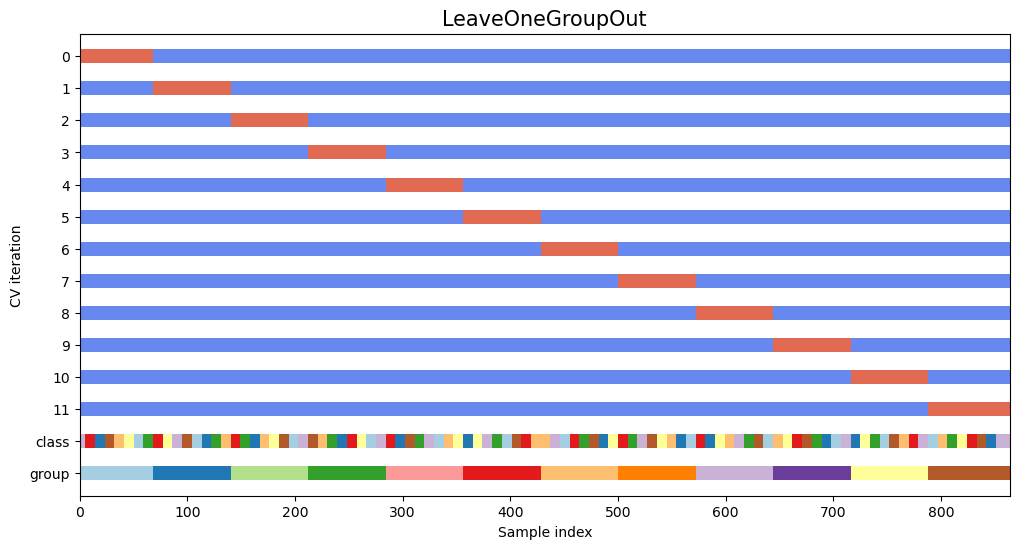

In [19]:
# Set up a couple variables for plotting
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
stimuli_map = {c: i for i, c in enumerate(categories)}
stimuli_int = [stimuli_map[s] for s in stimuli_task]

fig, ax = plt.subplots(figsize=(12, 6))
plot_cv_indices(cv, masker_vt.fit_transform(func_task),
                stimuli_int, runs_task, ax, 12);

### Classification model
Next, we'll load in Nilearn's `Decoder`, which provides a shortcut interface to some common classification models. We'll start with a basic support vector classifier (`svc`; [Boser et al., 1992](https://doi.org/10.1145/130385.130401)). There are a variety of ways to evaluate classifier performance. We'll use classification accuracy because this is a standard in the field (although other performance metrics maybe better; e.g. `roc_au`). Intialize the decoder with the SVC classifier using our leave-one-run-out cross-validation scheme above, specifying the VT mask and `accuracy` to evaluate performance. Get the cross-validated accuracy scores for the trained classifier.

In [23]:
func_task

(40, 64, 64, 864)

In [37]:
# Import nilearn's Decoder for SVM with cross-validation
from nilearn.decoding import Decoder

# Initialize Decoder with SVC, leave-one-out CV, and VT mask:
decoder = Decoder(estimator='svc', standardize=True,cv=cv,mask = masker_vt,scoring="accuracy")
# Fitting the decoder on the data across all CV folds:
decoder.fit(func_task,stimuli_task,groups = run_task)

# Get scores for each class and CV fold:
scores = decoder.cv_scores_

/usr/people/zj4962/miniconda3/envs/neu502b/lib/python3.11/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Print out the accuracy scores for each stumulus category below.

In [38]:
# Print classification accuracy for each class:
for stimulus,score in scores.items():
    print(stimulus+": "+str(np.mean(score)))

bottle: 0.5543981481481481
cat: 0.6643518518518517
chair: 0.6307870370370371
face: 0.6504629629629629
house: 0.6967592592592592
scissors: 0.699074074074074
scrambledpix: 0.7164351851851851
shoe: 0.6307870370370371


Rather than using Nilearn's convenient `Decoder` function, we can also use classifiers directly from scikit-learn. For example, here we'll recreate a similar model using scikit-learn's `LinearSVC`. First, initalize the classifier. Then, use `cross_val_score` to fit and evaluate the classifier; print the resulting accuracy scores.

In [48]:
# Load in automated cross-validation and classifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import warnings
cv = LeaveOneGroupOut()
svm = LinearSVC()
# X = masker_vt.transform(func_task)

svm = LinearSVC()
X = masker_vt.transform(func_task)
scores = []
for train, test in cv.split(X, stimuli_task, groups=runs_task):
    svm.fit(X[train], stimuli_task[train])
    y_pred = svm.predict(X[test])
    acc = accuracy_score(stimuli_task[test], y_pred)
    scores.append(acc)
    
# # Initialize SVC:
# svc_model = LinearSVC()
# # Run SVC with CV on VT data using cross_val_score:
# y_pred = cross_val_score(svc_model, 
#                 X=masker_vt.fit_transform(func_task), 
#                 y=stimuli_task, 
#                 cv = cv,
#                 groups=runs_task, 
#                 scoring="accuracy")




NameError: name 'accuracy_score' is not defined

In [46]:
y_pred

array([0.59722222, 0.54166667, 0.65277778, 0.66666667, 0.77777778,
       0.77777778, 0.61111111, 0.65277778, 0.69444444, 0.63888889,
       0.65277778, 0.72222222])

We can inspect classifier performance in more detail by visualizing the confusion matrix. Common metrics for quantifying classifer performance (e.g. accuracy, precision, AUROC) are summarizations of different aspects of the confusion matrix. Use `cross_val_predict` to re-run the classifier and store the predictions, then use `confusion_matrix` and `ConfusionMatrixDisplay` to visualize the confusion matrix.

In [45]:
# Plot confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Re-fit model to explicitly get predicted labels:
cm = confusion_matrix(stimuli_task,y_pred)
# Create confusion matrix from true and predicted labels:
ConfusionMatrixDisplay(confusion)
# Plot confusion matrix:


ValueError: Found input variables with inconsistent numbers of samples: [12, 864]

How "good" is our classification accuracy? Classification accuracy should be evaluated with respect to "chance" accuracy; i.e. the expected classification accuracy if the stimulus labels were randomly asigned. In a dataset with balanced class frequencies (i.e. same number of samples per class), the chance accuracy is typically $1 / n$ where $n$ is the number of distinct classes. For the current dataset, the chance accuracy is $1/8 = .125$.

### Randomizing labels
To reinforce our intuition about "chance" decoding accuracy, we can shuffle the stimulus labels and re-run the entire classification algorithm. Although too computationally demanding for this demo, we could repeat this randomization procedure many times (e.g. 1000 permutations) to construct a null distibution (under the null hypothesis that there is no systematic relationship between class labels and activity patterns). This would amount to a permutation test and allow us to derive a *p*-value corresponding to our classification score. Below, use `np.random.permutation` to shuffle the stimulus labels, then re-run the classifier with `cross_val_score` and interpret the resulting accuracy score.

In [ ]:
# Randomly shuffle labels prior to classification:
shuffled_labels = np.random.permutation(stimuli_task)

# Re-run classifier using cross_val_score:


### Visualizing the weight vectors
Similarly to regression, training a classifier model yields coefficients (or "weights") assigned to each feature in the model. Unlike the GLM, in the decoding framework, the features of the model are voxels; thus, a weight is assigned to each voxel indicating it's importance for successful classification. We can visualize these weights on the brain. Note, however, that these weight vectors are more difficult to interpret than activation maps ([Haufe et al., 2014](https://doi.org/10.1016/j.neuroimage.2013.10.067)). Let's go back to the Nilearn's fitted `Decoder` object from a previous cell. Extract the `coef_img_` for faces and for houses and visualize them using `plot_stat_map`.

In [ ]:
# Visualize the weight vector for the face class:
from nilearn.plotting import plot_stat_map


In [ ]:
# Visualize the weight vector for the house class:


### First-level GLM prior to classification
In the previous analyses, we have fed each time point corresponding to a given stimulus class into the classifier. However, for some experimental designs, it may be more appropriate to first perform a GLM, then supply the classifier with the beta weights (i.e. coefficients) from the GLM. This reduces the number of samples (i.e. response patterns) for the classifier, but may result in cleaner samples. Here, we'll use Nilearn's `FirstLevelModel` to run a GLM separately for each run, then provide the resulting contrast maps to the classifier.

In [ ]:
# Build first-level GLM for each run
from nilearn.glm.first_level import FirstLevelModel

tr = 2.5

events = {}
for run in np.unique(runs):
    stimuli_run = stimuli[runs == run]
    n_trs = len(stimuli_run)
    onset = tr * np.arange(n_trs)
    duration = np.full(n_trs, tr)
    
    events_all = pd.DataFrame(
        {'onset': onset, 'trial_type': stimuli_run, 'duration': duration})
    events[run] = events_all[events_all['trial_type'] != 'rest']

glm = FirstLevelModel(t_r=tr, hrf_model='spm',
                      mask_img=mask_vt,
                      drift_model='cosine',
                      high_pass=1/128,
                      standardize=True,
                      noise_model='ar1')

In [ ]:
# Fit the model and collect beta maps
glm_maps = []
glm_categories = []
glm_runs = []

for run in np.unique(runs):
    func_run = index_img(func_file, runs == run)
    glm.fit(func_run, events=events[run])
    for category in categories:
        glm_maps.append(glm.compute_contrast(category))
        glm_categories.append(category)
        glm_runs.append(run)
    print(f"Finished fitting GLM for run {run}")

In [ ]:
# Visualize the GLM report
from nilearn.image import mean_img
from nilearn.reporting import make_glm_report

func_mean = mean_img(func_file)
make_glm_report(glm,
                contrasts=categories,
                bg_img=func_mean,
                threshold=0,
                height_control=None)

Now, re-run the `Decoder` with the `glm_maps` produced above as input. Make sure to specify the `glm_categories` as your target variable, and specify `glm_runs` as the `groups` variable for leave-one-out cross-validation. How does the model perform on these GLM betas relative to the raw time series?

In [ ]:
# Fitting the decoder on the GLM data across runs:

# Get scores for each class and CV fold:

# Print classification accuracy for each class:


### Hyperparameter optimization using grid search
Most classification models have multiple hyperparameters that will affect performance; for example, in SVMs, the hyperparameter $C$ controls the width of the margin used when positioning the decision boundary. The best hyperparameter setting will vary from dataset to dataset. In order to chose the best hyperparameter(s) in an unbiased way, we can evaluate a variety of hyperarameter settings (referred to as a "grid") using cross-validation nested within each of our training samples. In our previous examples, this hyperparameter optimization was either performed under the hood, or the software's default hyperparameter was used. Here, we'll use a larger grid of settings for $C$ in hopes of improving classification performance.

In [ ]:
# Create grid of C hyperparameter settings
param_grid = {'C': np.logspace(-8, 2, 11)}
print(f"C hyperparamater grid:\n {param_grid['C']}")

In [ ]:
# Fit classification model with hyperparameter grid
decoder = Decoder(estimator='svc', cv=cv,
                  mask=mask_vt, scoring='accuracy',
                  param_grid=param_grid,
                  standardize=False)
decoder.fit(glm_maps, glm_categories, groups=glm_runs)

# Get scores for each class and CV fold
scores = decoder.cv_scores_

# Print classification accuracy for each class
for category in categories:
    print(f"Mean classification accuracy for {category} "
          f"stimuli: {np.mean(scores[category]):.3f}")
print("Overall mean classification accuracy: "
      f"{np.mean([scores[c] for c in categories]):.3f}")

### Revisiting the local vs. distributed debate
Finally, we can incorporate the functional localizer masks for cortical areas that are maximally responsive to faces and houses. Haxby and colleagues demonstrated that even cortical areas that prefer e.g. faces encode information about houses and other object categories.

In [ ]:
# Loop through each ROI and run decoding model
roi_masks = {'VT':'mask_vt', 'face':'mask_face', 'house':'mask_house'}

roi_accuracies = {}
for roi in roi_masks:
    mask_file = haxby_dataset[roi_masks[roi]][0]
    decoder = Decoder(estimator='svc', cv=cv,
                      mask=mask_file, scoring='accuracy')
    decoder.fit(func_task, stimuli_task, groups=runs_task)
    roi_accuracies[roi] = decoder.cv_scores_
    print(f"Finished decoding analysis for {roi} cortex")

In [ ]:
# Plot accuracies for all three ROIs
import seaborn as sns

roi_long = {'ROI': [], 'category': [], 'accuracy': []}
for roi in roi_accuracies:
    for category in roi_accuracies[roi]:
        for acc in roi_accuracies[roi][category]:
            roi_long['ROI'].append(roi)
            roi_long['category'].append(category)
            roi_long['accuracy'].append(acc)
roi_long = pd.DataFrame(roi_long)

sns.barplot(data=roi_long, x='category', y='accuracy', hue='ROI')
plt.axhline(.125, linestyle='--', color='white');

#### References
* Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992). A training algorithm for optimal margin classifiers. In *Proceedings of the Fifth Annual Workshop on Computational Learning Theory* (pp. 144-152). https://doi.org/10.1145/130385.130401

* Haufe, S., Meinecke, F., Görgen, K., Dähne, S., Haynes, J. D., Blankertz, B., & Bießmann, F. (2014). On the interpretation of weight vectors of linear models in multivariate neuroimaging. *NeuroImage*, *87*, 96-110. https://doi.org/10.1016/j.neuroimage.2013.10.067

* Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. *Science*, *293*(5539), 2425–2430. https://doi.org/10.1126/science.1063736